In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os

In [2]:
data_path = Path(r"C:\Users\schne\Desktop\Fish\Fish_Dataset\Fish_Dataset")
file_path = list(data_path.glob(r"**/*.png"))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],file_path))

In [3]:
import pandas as pd

file_path = pd.Series(file_path).astype(str)
Labels = pd.Series(Labels)

df = pd.concat([file_path, Labels], axis=1)

df.columns = ['image', 'label']
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True) #Drops extra folders
df.head()

,image,label
0,C:\Users\schne\Desktop\Fish\Fish_Dataset\Fish_...,Black Sea Sprat
1,C:\Users\schne\Desktop\Fish\Fish_Dataset\Fish_...,Black Sea Sprat
2,C:\Users\schne\Desktop\Fish\Fish_Dataset\Fish_...,Black Sea Sprat
3,C:\Users\schne\Desktop\Fish\Fish_Dataset\Fish_...,Black Sea Sprat
4,C:\Users\schne\Desktop\Fish\Fish_Dataset\Fish_...,Black Sea Sprat


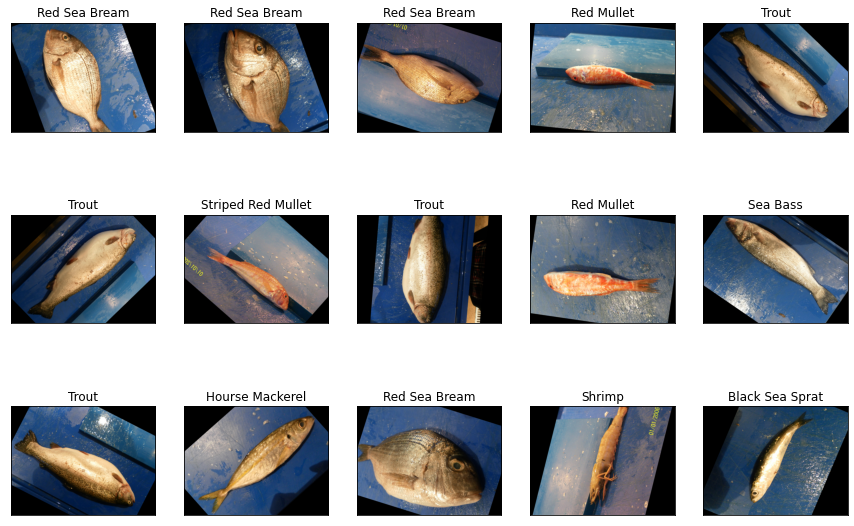

In [4]:
# Displays 15 random images from dataset
df_ran = df.sample(n = 15, random_state=7991).reset_index()
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_ran.image[i],0))
    ax.set_title(df_ran.label[i])
    
plt.show()

In [5]:
# Shows category counts
df.label.value_counts()

Sea Bass              1000
Shrimp                1000
Red Sea Bream         1000
Trout                 1000
Gilt-Head Bream       1000
Red Mullet            1000
Striped Red Mullet    1000
Black Sea Sprat       1000
Hourse Mackerel       1000
Name: label, dtype: int64

In [6]:
# Create Training, Validation and Testing sets
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(df, test_size=0.2,random_state=7991)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=7991)
print("Shape of each dataset")
print("Training: ", x_train.shape)
print("Test: ", x_test.shape)
print("Validation: ", x_val.shape)

Shape of each dataset
Training:  (5760, 2)
Test:  (1800, 2)
Validation:  (1440, 2)


In [7]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
input_shape = (200, 200, 3)
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 5760 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.


In [8]:
# Third Structure Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 128)       7

In [11]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train, validation_data=val, epochs=20, callbacks=callback)
model.save('Third_Structure_20.h5')

Epoch 1/20
180/180 [==============================] - 151s 833ms/step - loss: 1.8259 - accuracy: 0.2439 - val_loss: 1.5684 - val_accuracy: 0.3181
Epoch 2/20
180/180 [==============================] - 120s 668ms/step - loss: 1.5327 - accuracy: 0.3406 - val_loss: 1.4099 - val_accuracy: 0.3993
Epoch 3/20
180/180 [==============================] - 123s 685ms/step - loss: 1.4482 - accuracy: 0.3747 - val_loss: 1.2720 - val_accuracy: 0.4340
Epoch 4/20
180/180 [==============================] - 118s 656ms/step - loss: 1.3199 - accuracy: 0.4271 - val_loss: 1.3143 - val_accuracy: 0.4257
Epoch 5/20
180/180 [==============================] - 118s 656ms/step - loss: 1.1231 - accuracy: 0.5116 - val_loss: 0.9869 - val_accuracy: 0.5847
Epoch 6/20
180/180 [==============================] - 118s 655ms/step - loss: 0.9936 - accuracy: 0.5896 - val_loss: 0.8908 - val_accuracy: 0.6424
Epoch 7/20
180/180 [==============================] - 118s 654ms/step - loss: 0.8377 - accuracy: 0.6708 - val_loss: 0.8317 -

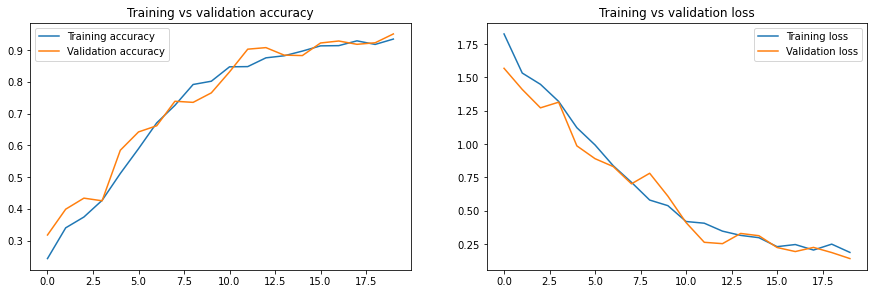

In [12]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

pred = model.predict(test)
pred = np.argmax(pred, axis=1)
labels = train.class_indices
labels = dict((v,k) for k, v in labels.items())
y_pred = [labels[k] for k in pred]

print(classification_report(x_test.label, y_pred))
print(confusion_matrix(x_test.label, y_pred))
test_accuracy = model.evaluate(test)[1]

                    precision    recall  f1-score   support

   Black Sea Sprat       0.97      0.97      0.97       203
   Gilt-Head Bream       0.87      0.83      0.85       210
   Hourse Mackerel       0.98      0.96      0.97       205
        Red Mullet       1.00      1.00      1.00       182
     Red Sea Bream       0.87      0.91      0.89       220
          Sea Bass       0.93      0.95      0.94       209
            Shrimp       0.99      0.99      0.99       183
Striped Red Mullet       0.97      1.00      0.98       201
             Trout       0.99      0.97      0.98       187

          accuracy                           0.95      1800
         macro avg       0.95      0.95      0.95      1800
      weighted avg       0.95      0.95      0.95      1800

[[197   0   1   0   0   5   0   0   0]
 [  0 175   0   0  24   9   0   2   0]
 [  5   1 196   0   0   1   1   1   0]
 [  0   0   0 182   0   0   0   0   0]
 [  0  18   0   0 200   0   0   1   1]
 [  0   7   2   0   0 

In [14]:
Test_Output=model.predict(test)

In [15]:
y_pred = pd.Series(y_pred)
Output_Testing=pd.concat([y_pred], axis=1).reset_index()

In [19]:
Counts=Output_Testing.groupby([0]).count().reset_index()
Counts

,0,index
0,Black Sea Sprat,203
1,Gilt-Head Bream,202
2,Hourse Mackerel,199
3,Red Mullet,182
4,Red Sea Bream,229
5,Sea Bass,214
6,Shrimp,182
7,Striped Red Mullet,206
8,Trout,183


In [30]:
model = tf.keras.models.load_model('Third_Structure_20.h5')

In [34]:
model.weights

[<tf.Variable 'conv2d_6/kernel:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
 array([[[[-8.35736096e-02,  2.81037792e-05, -1.14825040e-01,
           -5.21198921e-02,  1.55351877e-01, -8.97981375e-02,
            4.09876928e-02, -1.00698262e-01,  1.38801798e-01,
           -8.27426615e-04,  1.19865306e-01,  1.43744694e-02,
            5.73836267e-02,  1.76487774e-01,  9.07955021e-02,
           -1.14576384e-01],
          [ 1.10845290e-01,  1.97422594e-01, -9.97894406e-02,
            5.41796573e-02, -3.95598337e-02,  8.25250000e-02,
           -4.48509902e-02, -8.46535340e-02, -1.51580751e-01,
            1.80597618e-01,  1.00192530e-02,  1.90667838e-01,
           -3.61638293e-02,  1.68040365e-01, -8.34465697e-02,
            2.51471419e-02],
          [-1.73336387e-01, -5.31577505e-02,  7.28373230e-02,
           -1.10138968e-01, -2.28902623e-01, -1.41674176e-01,
           -2.84030348e-01,  1.46405593e-01,  3.57722528e-02,
           -1.08067118e-01,  3.36683467e-02,  1.78880677e-01